1. Gerekli kütüphaneler

In [1]:
# 📌 Gerekli Kütüphaneler
import pandas as pd
import numpy as np

# Modelleme ve Değerlendirme
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay
import joblib

# Görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

2. Veriyi okuma

In [2]:
# Verileri oku
train_df = pd.read_csv("../datasets/pca/train_mental_pca.csv")
test_df = pd.read_csv("../datasets/pca/test_mental_pca.csv")

# Özellik ve hedef ayır
X_train = train_df.drop("treatment", axis=1)
y_train = train_df["treatment"]
X_test = test_df.drop("treatment", axis=1)
y_test = test_df["treatment"]

3. SelectKBest ile en iyi öznitelik seçimi

In [3]:
# Öznitelik seçimi (k=10)
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X_train, y_train)

# Seçilen öznitelik isimlerini al
selected_features = X_train.columns[selector.get_support()]

print("🎯 Seçilen en iyi 10 öznitelik:")
print(selected_features)

🎯 Seçilen en iyi 10 öznitelik:
Index(['0', '1', '2', '4', '6', '8', '9', '11', '15', '19'], dtype='object')


In [4]:
X_test_selected = selector.transform(X_test)

4. GridSearchCV ile Hyperparameter tuning

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

# Parametre grid'ini penalty'ye göre ayırıyoruz:
param_grid = [
    {"penalty": ["l1"], "solver": ["saga"], "C": [0.01, 0.1, 1, 10, 100]},
    {"penalty": ["l2"], "solver": ["saga"], "C": [0.01, 0.1, 1, 10, 100]},
    {"penalty": ["elasticnet"], "solver": ["saga"], "C": [0.01, 0.1, 1, 10, 100], "l1_ratio": [0.0, 0.5, 1.0]},
    {"penalty": [None], "solver": ["saga"]}  # Buradaki düzeltme: "none" → None
]

# GridSearch
grid_search = GridSearchCV(
    logreg, 
    param_grid, 
    scoring="roc_auc", 
    cv=5, 
    n_jobs=-1, 
    verbose=1
)
grid_search.fit(X_selected, y_train)

print("✅ En iyi parametreler:")
print(grid_search.best_params_)
print("🌟 En iyi ROC AUC skoru:")
print(grid_search.best_score_)

Fitting 5 folds for each of 26 candidates, totalling 130 fits
✅ En iyi parametreler:
{'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
🌟 En iyi ROC AUC skoru:
0.7735270707070707


4. Modelin En İyi Parametrelerle Eğitimi ve testi

In [6]:
# 📌 Model tanımı (En iyi parametrelerle)
best_model = LogisticRegression(
    C=0.1,
    penalty="elasticnet",
    solver="saga",
    l1_ratio=0.5,
    max_iter=10000,
    class_weight="balanced",
    random_state=42
)

# 📌 Modeli eğit
best_model.fit(X_train, y_train)

# 📌 Tahmin ve olasılık hesapla
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

5. Değerlendirme

📋 Sınıflandırma Raporu (Logistic Regression):

              precision    recall  f1-score   support

           0       0.68      0.72      0.70       124
           1       0.71      0.67      0.69       125

    accuracy                           0.69       249
   macro avg       0.70      0.69      0.69       249
weighted avg       0.70      0.69      0.69       249



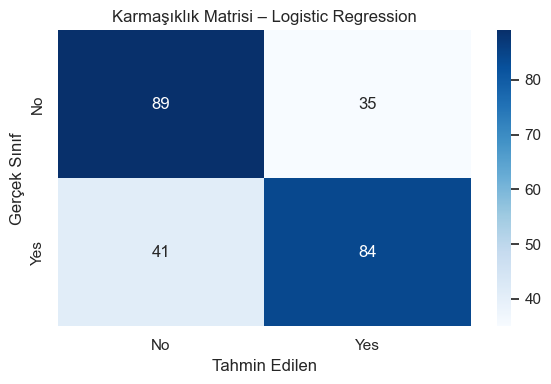

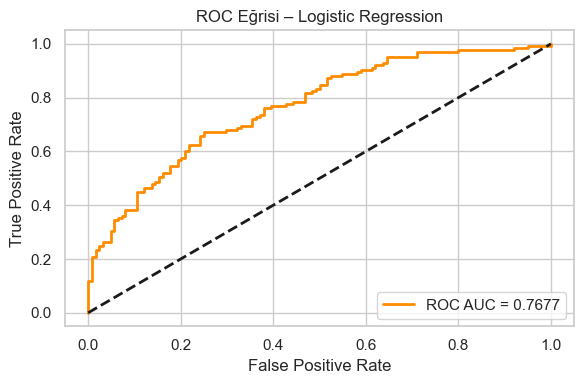

In [7]:
# 📋 Sınıflandırma Raporu
print("📋 Sınıflandırma Raporu (Logistic Regression):\n")
print(classification_report(y_test, y_pred))

# 📌 Confusion Matrix (Karmaşıklık Matrisi)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.title("Karmaşıklık Matrisi – Logistic Regression")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Sınıf")
plt.tight_layout()
plt.show()

# 📌 ROC Curve (ROC Eğrisi)
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}", color="darkorange", lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title("ROC Eğrisi – Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()